In [16]:
import subprocess
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../../utils')
import config_handling as conf
from database import Database
from file_io import path_handler

In [2]:
config = conf.read_config('../../config/automotive.conf.ini')
config.read('config.ini')
connection_type = config['settings']['connection']
connection_type
user = config[connection_type]['user']
pw = config[connection_type]['pw']
host = config[connection_type]['host']
db = config[connection_type]['db']
port = config[connection_type].getint('port')
db = Database(host,
              port,
              user,
              pw,
              db
              )
db.connect()
#image directory: 
basedir = config['settings']['image_directory']

Connection established


# 1 Data properties: Organization and volume
In a first step let's see how big the data really is, what do we have in the database and how is it structured. There's also data in the filesystem (image files)

In [9]:
tables = db.execute_query('SHOW TABLES')
counts = []
for table in tables:
    tablename =table['Tables_in_automotive']
    c = db.execute_query(f'SELECT COUNT(*) AS f FROM {tablename}')
    counts.append([tablename, c[0]['f']])


In [11]:
pd.DataFrame(counts, columns=['table', 'records'])

,table,records
0,angletags,4335
1,images,15647260
2,listings,829374
3,models,0
4,tracker,0


In [17]:
os.chdir(basedir)
subprocess.run(['du', '-h', '-s'])

839G	.


CompletedProcess(args=['du', '-h', '-s'], returncode=0)

So we have about 15.6 million images; for about 830000 listings. This translates to an image directory with a size of 839GB. That is the high level view of the data; how is this data spread across different brands?

In [32]:
brand_listings_query = "SELECT brand, COUNT(*) AS nr_of_listings FROM listings GROUP BY listings.brand"
brand_images_query = "SELECT brand, COUNT(*) AS nr_of_images FROM listings JOIN images ON images.listing_id = listings.id GROUP BY listings.brand"

listings_per_brand = db.execute_query(brand_listings_query)
images_per_brand = db.execute_query(brand_images_query)

In [39]:
listings_brand_df = pd.DataFrame(listings_per_brand)
images_brand_df = pd.DataFrame(images_per_brand)
frequency_table = pd.merge(listings_brand_df, images_brand_df)
frequency_table.sort_values(by='nr_of_listings', ascending=False, inplace=True)


/tmp/ipykernel_5492/1903859047.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels = frequency_table['brand'], rotation=45, ha='right')
/tmp/ipykernel_5492/1903859047.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(labels = frequency_table['brand'], rotation=45, ha='right')


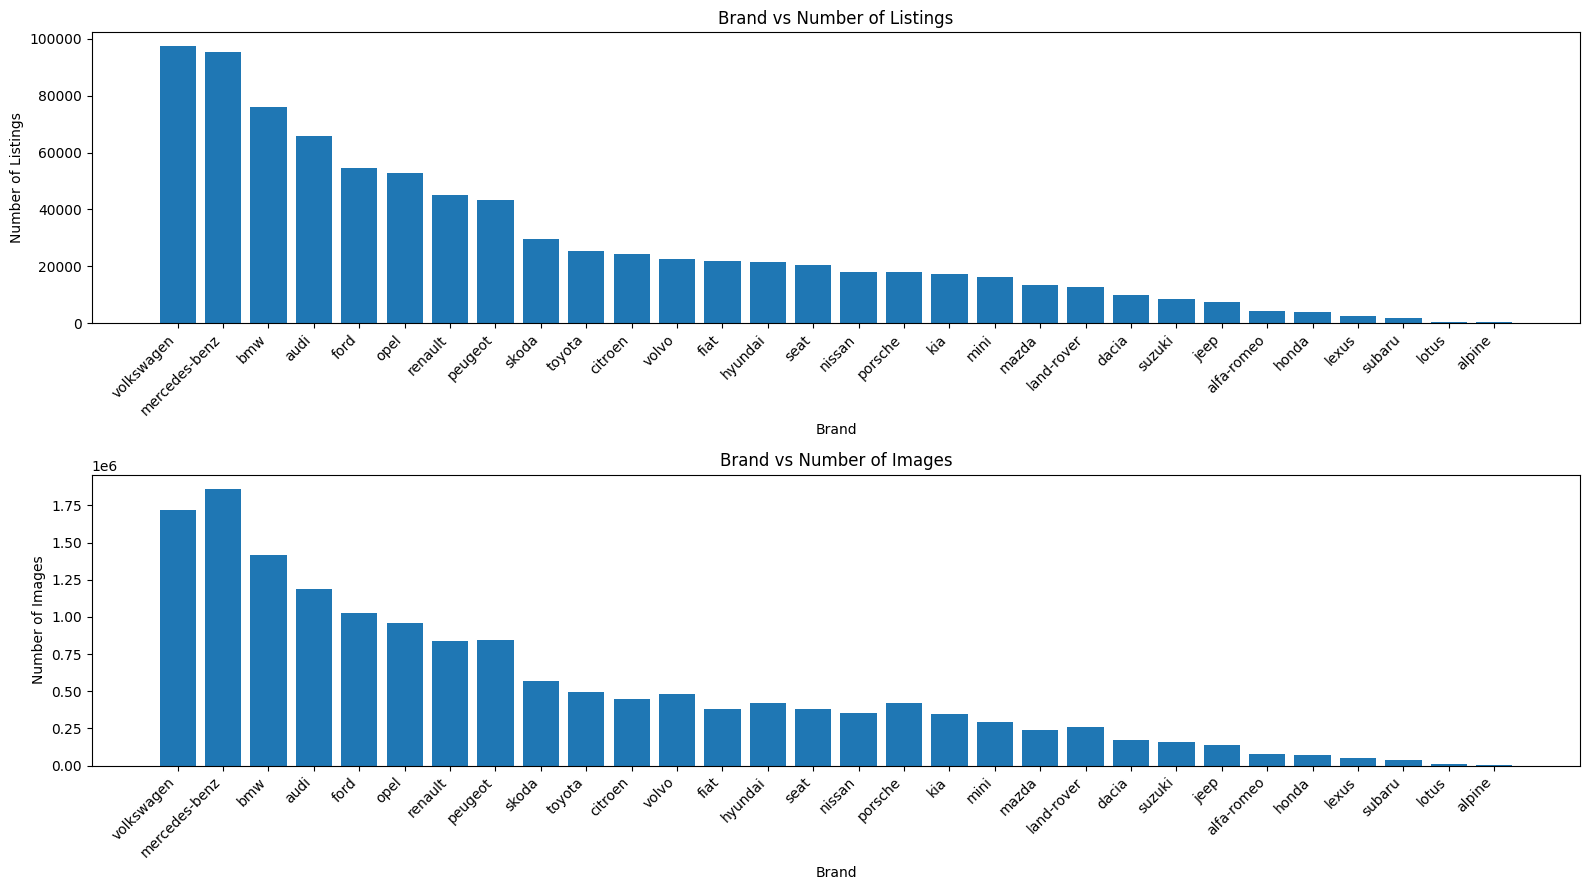

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(16, 9))
ax[0].bar(frequency_table['brand'], frequency_table['nr_of_listings'])
ax[0].set_title('Brand vs Number of Listings')
ax[0].set_xticklabels(labels = frequency_table['brand'], rotation=45, ha='right')
ax[0].set_xlabel('Brand')
ax[0].set_ylabel('Number of Listings')

ax[1].bar(frequency_table['brand'], frequency_table['nr_of_images'])
ax[1].set_title('Brand vs Number of Images')
ax[1].set_xticklabels(labels = frequency_table['brand'], rotation=45, ha='right')
ax[1].set_xlabel('Brand')
ax[1].set_ylabel('Number of Images')

fig.tight_layout()

In [51]:
#distribution per country for overall dataset
country_listings_query = "SELECT count(*) AS nr_of_listings, countrycode FROM listings group by countrycode"
listings_per_country = db.execute_query(country_listings_query)
listings_country_df = pd.DataFrame(listings_per_country)

In [67]:
country_full_names = {
    'D': 'Germany',
    'B': 'Belgium',
    'NL': 'Netherlands',
    'F': 'France'
}

color_mapping = {
    'D': '#ff2605',     #red
    'B': '#f7ff05',     #yellow
    'NL': '#ff9b05',    #orange
    'F': '#1e05ff'      #blue
}


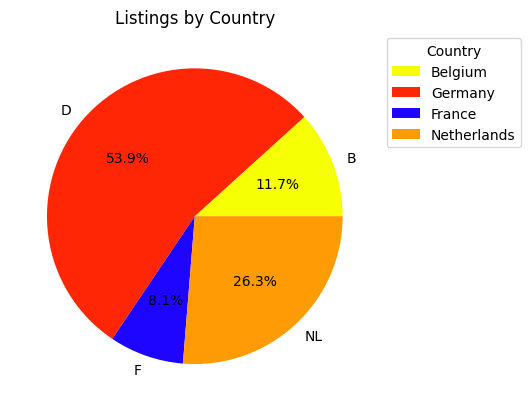

In [68]:
colors = [color_mapping[code] for code in listings_country_df['countrycode']]

plt.pie(
    x = listings_country_df['nr_of_listings'], 
    labels=listings_country_df['countrycode'],
    autopct='%1.1f%%',
    colors=colors
)
plt.title("Listings by Country")
legend_labels = [country_full_names[code] for code in listings_country_df['countrycode']]
plt.legend(legend_labels, title="Country", loc="upper left", bbox_to_anchor=(1, 1))


In [71]:
brand_country_listings_query = "SELECT brand, countrycode, count(*) AS nr_of_listings FROM listings GROUP BY brand, countrycode"
brand_country_listings = db.execute_query(brand_country_listings_query)
listings_brand_country_df = pd.DataFrame(brand_country_listings)

In [72]:
listings_brand_country_df

,brand,countrycode,nr_of_listings
0,alfa-romeo,B,603
1,alfa-romeo,D,2000
2,alfa-romeo,F,435
3,alfa-romeo,NL,1280
4,alpine,B,23
...,...,...,...
115,volkswagen,NL,25515
116,volvo,B,2442
117,volvo,D,9765
118,volvo,F,861


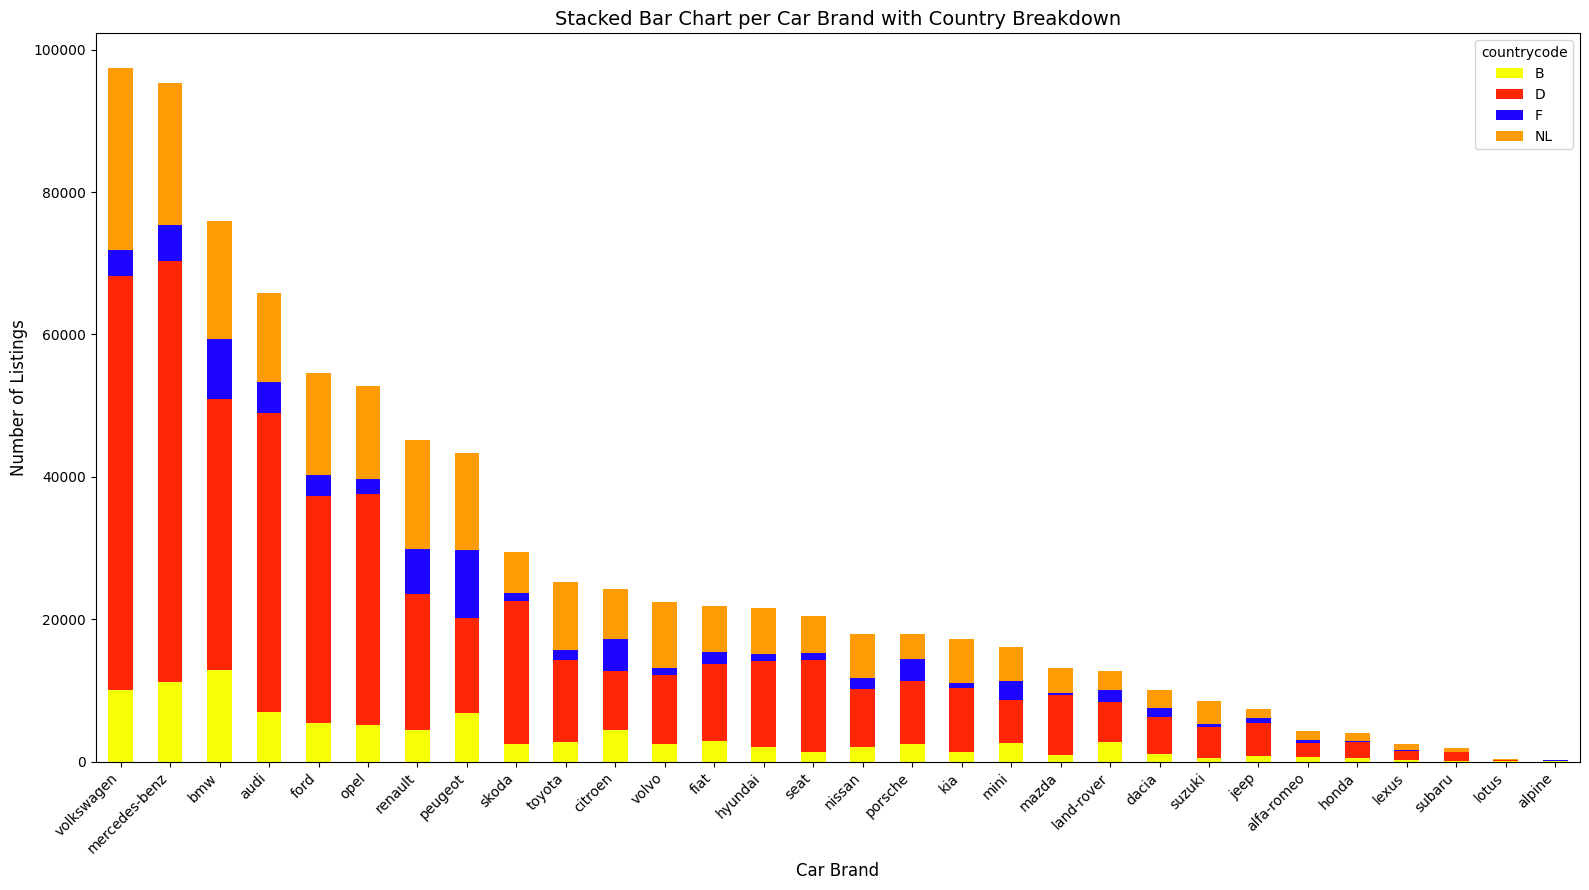

In [77]:
pivot_df = listings_brand_country_df.pivot_table(index='brand', columns='countrycode', values='nr_of_listings', aggfunc='sum', fill_value=0)
pivot_df['total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values('total', ascending=False).drop(columns='total')
# Create a stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(16, 9), color=[color_mapping[c] for c in pivot_df.columns])

# Labeling
ax.set_title('Stacked Bar Chart per Car Brand with Country Breakdown', fontsize=14)
ax.set_xlabel('Car Brand', fontsize=12)
ax.set_ylabel('Number of Listings', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

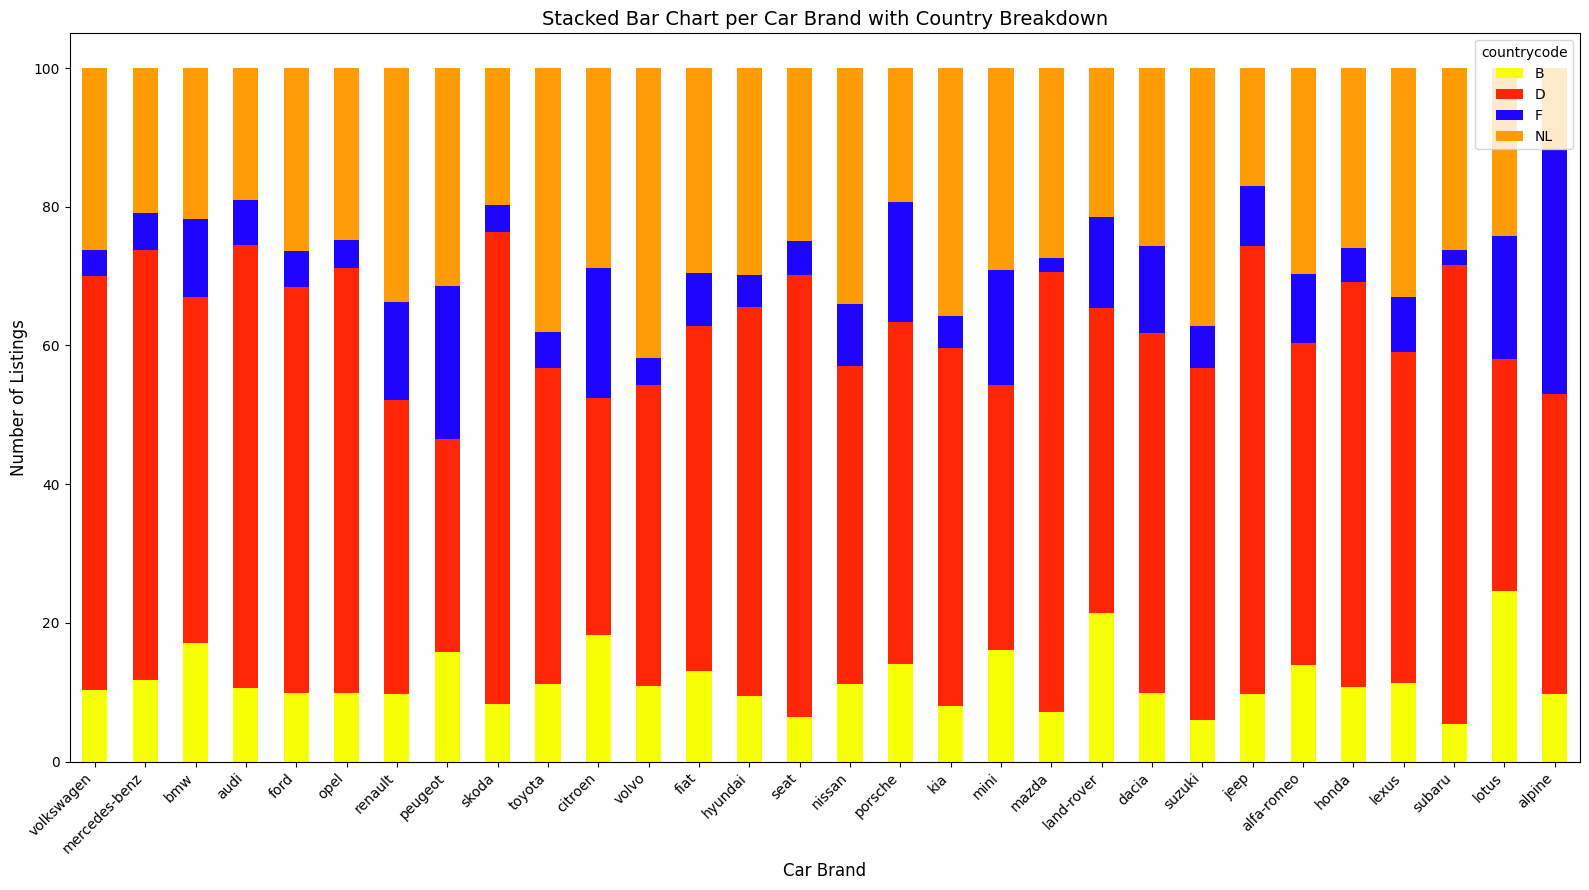

In [94]:
pivot_df_relative = pivot_df.copy()
pivot_df_relative['total'] = pivot_df.sum(axis=1)
for key in color_mapping:
    pivot_df_relative[key] = pivot_df_relative[key]/pivot_df_relative['total']*100
pivot_df_relative = pivot_df_relative.drop(columns='total')
ax = pivot_df_relative.plot(kind='bar', stacked=True, figsize=(16, 9), color=[color_mapping[c] for c in pivot_df_relative.columns])

# Labeling
ax.set_title('Stacked Bar Chart per Car Brand with Country Breakdown', fontsize=14)
ax.set_xlabel('Car Brand', fontsize=12)
ax.set_ylabel('Number of Listings', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

In [107]:
#inspecting models/model distribution 
model_distribution_query = "SELECT brand, model, model_id FROM listings"
model_distribution = db.execute_query(model_distribution_query)
listings = pd.DataFrame(model_distribution)
shuffled_listings = listings.sample(frac=1, random_state=42).reset_index(drop=True)

In [116]:
tracker = set()
population_uq_items = []
populationsize = []
pop = 1
for row in shuffled_listings.iterrows():
    row = row[1]
    name = f"{row['brand']}-{row['model']}-{row['model_id']}"
    tracker.add(name)
    populationsize.append(pop)
    population_uq_items.append(len(tracker))
    pop+=1

In [117]:
del(tracker)

''

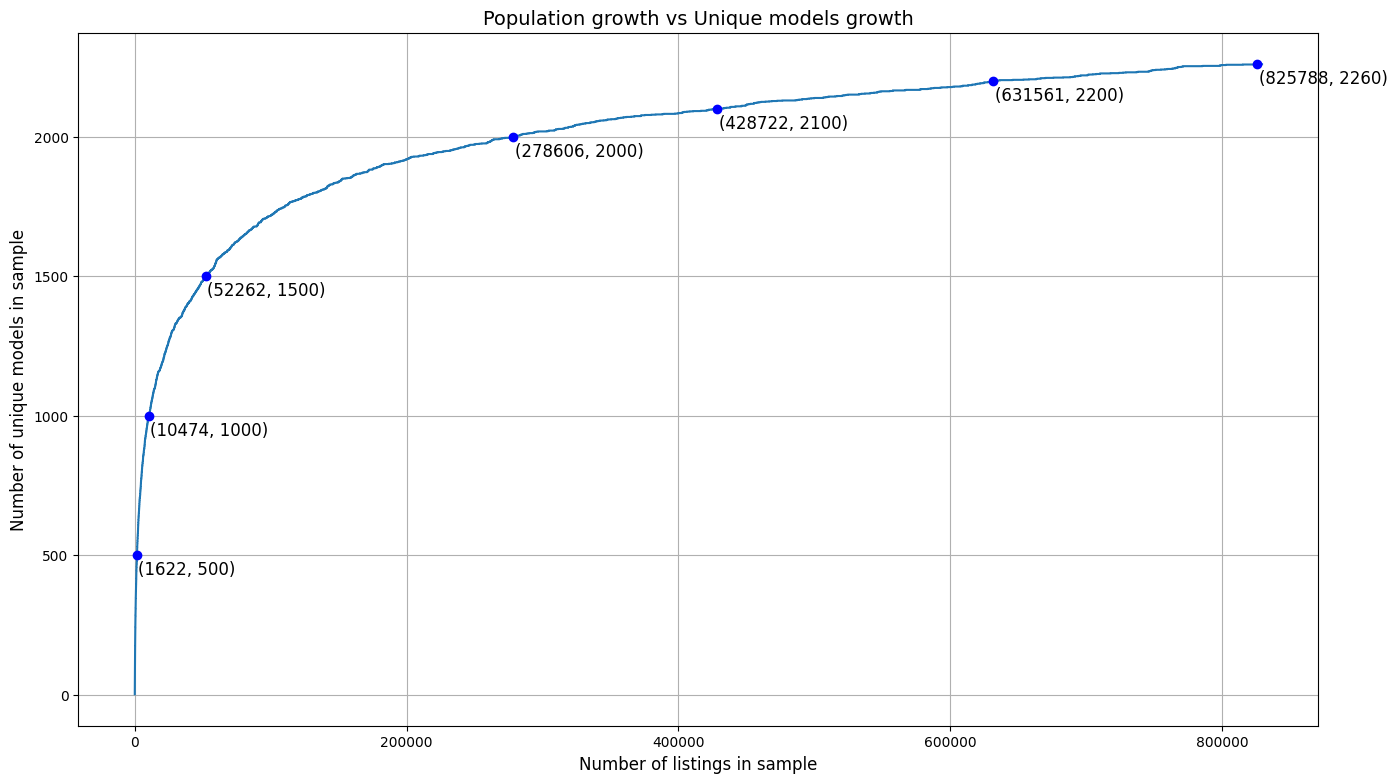

In [161]:
plt.figure(figsize=(16, 9))
plt.plot(populationsize, population_uq_items)
plt.title('Population growth vs Unique models growth', fontsize = 14)
plt.xlabel('Number of listings in sample', fontsize= 12)
plt.ylabel('Number of unique models in sample', fontsize = 12)
plt.grid(visible=True)
x_padding = 1000
y_padding = -20
for y_val in [500, 1000, 1500, 2000, 2100, 2200, max(population_uq_items)]:
    if y_val in population_uq_items:  # Ensure that the Y-values exist in the data
        x_val = populationsize[population_uq_items.index(y_val)]
        plt.plot(x_val, y_val, marker='o', color='blue')
        plt.text(x_val+x_padding, y_val+y_padding, f'({x_val}, {y_val})', fontsize=12, horizontalalignment='left', verticalalignment='top')


;

# 2 let's dive in: 
We know how the data roughly looks like, what does an entry look like?

In [166]:
pd.set_option('display.max_columns', None)

In [162]:
all_listings_query = "SELECT * FROM listings"
all_listings = db.execute_query(all_listings_query)
all_listings_df = pd.DataFrame(all_listings)

In [163]:
all_listings_df.isna().sum()

id                           0
autoscout_id                 0
brand                        0
model                        0
year                         0
first_registration           0
make_name_autoscout          0
model_name_autoscout         0
price                        0
mileage                      0
make_id                      0
model_id                217442
variant_id              645458
generation_id           630417
motortype_id            641148
trim_id                 808414
shelltype                    3
doorcount                10976
weight                  209143
normlabel               230422
countrycode                  0
dtype: int64

In [167]:

all_listings_df.sample(5)

,id,autoscout_id,brand,model,year,first_registration,make_name_autoscout,model_name_autoscout,price,mileage,make_id,model_id,variant_id,generation_id,motortype_id,trim_id,shelltype,doorcount,weight,normlabel,countrycode
482408,510550,d8502b70-05f0-46e6-9bf1-49ea6ea0640d,kia,Sportage,2017,05-2017,kia,sportage,12990,170400,39,NaN,NaN,NaN,NaN,NaN,SUV/4x4/Pick-up,4.0,NaN,EURO6,D
167462,173283,48fb6d67-add8-4d40-8113-346981b201d2,hyundai,i20,2021,05-2021,hyundai,i20,16980,36842,33,19188.0,NaN,NaN,NaN,NaN,Berline,5.0,1.0,EURO6d,D
547791,575933,41bc02d9-cfdc-4859-a133-f440c0820ba5,skoda,Kodiaq,2024,11-2024,skoda,kodiaq,36290,10,65,74375.0,NaN,NaN,NaN,NaN,SUV/4x4/Pick-up,5.0,2.0,None,F
79888,85709,e6cfce8f-bbc3-4382-8126-ae1314a6c417,citroen,C3 (alle),2012,07-2012,citroen,c3,5250,56525,21,18264.0,NaN,NaN,NaN,NaN,Berline,5.0,1.0,EURO5,B
486097,514239,3d437840-47f6-4c0e-890c-d67ff9da76f4,kia,Picanto,2023,06-2023,kia,picanto,12290,7600,39,NaN,NaN,NaN,NaN,NaN,Berline,4.0,974.0,None,D


In [168]:
basedir

'/home/frederic/Documents/automotive_image_data'